In [70]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import nltk

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.preprocessing import LabelBinarizer

from keras.models import Model
from keras.layers import Input, Dense, Flatten, Dropout, Embedding
from keras.layers.convolutional import Conv1D, MaxPooling1D,Conv2D
from tensorflow.keras.layers import concatenate
from keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from scipy import sparse, stats
import utils.text_processing as util
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras import models, layers, preprocessing as kprocessing
## for word embedding
import gensim
import seaborn as sns

from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing

In [71]:
#Parameters
OUTPUT_CLASSES = 22
FILE_NAME = "../Data/processed_data.csv"
SEQUENCE_LENGTH = 125
EMBEDDING_SIZES =[300,300]
BATCH_SIZE = 32
EPOCH_LENGTH = 10
VALIDATION_PERCENTAGE = 0.1
TEST_SIZE_PERCENTAGE = 0.2
Y_LABEL_NAME="username"
X_LABEL_NAME="raw_text"
COV_FILTERS = [300,350,250,250]
FILTER_SIZES = [1, 1,1,1]
NUMBER_K_FOLDS = 3
LEARNING_RATE = 0.0005
VERBOSE = 1


In [72]:
def define_model(input_len, output_size, embedding_dims, verbose = True,
                drop_out_pct = 0.25, conv_filters = 500, activation_fn = 'tanh', pool_size = 4, learning = 0.0005):

   # Sub network 1
    #(None, 15, 1)
    inputs1 = Input(shape=(input_len, ))
    embedding1 = Embedding(input_length=input_len,weights=[embedding_dims],trainable=False,input_dim=embedding_dims.shape[0], output_dim=embedding_dims.shape[1])(inputs1)
    conv1_1 = Conv1D(filters = COV_FILTERS[0], kernel_size = FILTER_SIZES[0], activation = activation_fn, padding='same')(embedding1)
    conv1_2 = Conv1D(filters = COV_FILTERS[1], kernel_size = FILTER_SIZES[1], activation = activation_fn)(conv1_1)
    #pool1 = MaxPooling1D(pool_size = pool_size , padding='same')(conv1_2)
    conv1_3 = Conv1D(filters = COV_FILTERS[2], kernel_size = FILTER_SIZES[2], activation = activation_fn)(conv1_2)
    conv1_4 = Conv1D(filters = COV_FILTERS[3], kernel_size = FILTER_SIZES[3], activation = activation_fn)(conv1_3)
    #pool2 = MaxPooling1D(pool_size = pool_size, padding='same')(conv1_1)
    dense1 = Dense(400, activation = 'sigmoid')(conv1_4)
    flat1 = Flatten()(dense1)
    
    # Sub network 2
    inputs2 = Input(shape=(input_len, ))
    embedding2 = Embedding(input_length=5,weights=[embedding_dims],trainable=False,input_dim=embedding_dims.shape[0], output_dim=embedding_dims.shape[1])(inputs2)
    conv2_1 = Conv1D(filters = COV_FILTERS[0], kernel_size = FILTER_SIZES[0], activation = activation_fn, padding='same')(embedding2)
    conv2_2 = Conv1D(filters = COV_FILTERS[1], kernel_size = FILTER_SIZES[1], activation = activation_fn)(conv2_1)
    #pool3 = MaxPooling1D(pool_size = pool_size , padding='same')(conv2_2)
    conv2_3 = Conv1D(filters = COV_FILTERS[2], kernel_size = FILTER_SIZES[2], activation = activation_fn)(conv2_2)
    conv2_4 = Conv1D(filters = COV_FILTERS[3], kernel_size = FILTER_SIZES[3], activation = activation_fn)(conv2_3)
    #pool4 = MaxPooling1D(pool_size = pool_size, padding='same')(conv2_1)
    dense2 = Dense(400, activation = 'sigmoid')(conv2_4)
    flat2 = Flatten()(dense2)


    # Merge channels
    merged = concatenate([flat1, flat2])
    
    # Create output layer
    #dense = Dense(10, activation = 'sigmoid')(merged)
    output = Dense(output_size, activation = 'softmax')(merged)

    # Create model
    model = Model(inputs = [inputs1, inputs2], outputs = output)
    
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer = Adam(learning_rate = learning), metrics=['accuracy'])
    
    if verbose:
        print(model.summary())
        
    return model

In [73]:
#Read data
data = pd.read_csv(FILE_NAME)

In [74]:
#Get text and y label
text = data[X_LABEL_NAME]
author = data[Y_LABEL_NAME]

In [75]:
#Split data
text_train, text_test, author_train, author_test = train_test_split(text, author, test_size = TEST_SIZE_PERCENTAGE, random_state = 5)

In [76]:
## create list of lists of unigrams
corpus = []
train_corpus = []
test_corpus = []

for string in text:
   words = string.split()
   one_grams = [" ".join(words[i:i+1])
               for i in range(0, len(words), 1)]
   corpus.append(one_grams)

for string in text_train:
   words = string.split()
   one_grams = [" ".join(words[i:i+1])
               for i in range(0, len(words), 1)]
   train_corpus.append(one_grams)

for string in text_test:
   words = string.split()
   one_grams = [" ".join(words[i:i+1])
               for i in range(0, len(words), 1)]
   test_corpus.append(one_grams)


## tokenize text
tokenizer = kprocessing.text.Tokenizer(lower=True, split=' ', 
                     oov_token="NaN", 
                     filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')

tokenizer.fit_on_texts(corpus)
dic_vocabulary = tokenizer.word_index

In [77]:
## create sequence
lst_text2seq= tokenizer.texts_to_sequences(train_corpus)
## padding sequence
X_train = kprocessing.sequence.pad_sequences(lst_text2seq, 
                    maxlen=35, padding="post", truncating="post")

# text to sequence with the fitted tokenizer
lst_text2seq = tokenizer.texts_to_sequences(test_corpus)
## padding sequence
X_test = kprocessing.sequence.pad_sequences(lst_text2seq, maxlen=35,
             padding="post", truncating="post")


In [78]:
nlp = gensim.models.word2vec.Word2Vec(corpus, vector_size=300, window=8, min_count=1, workers=4,sg=1)

In [79]:
## start the matrix (length of vocabulary x vector size) with all 0s
embeddings = np.zeros((len(dic_vocabulary)+1, 300))
for word,idx in dic_vocabulary.items():
    ## update the row with vector
    try:
        embeddings[idx] =  nlp.wv[word]
    ## if word not in model then skip and the row stays all 0s
    except:
        pass

In [80]:
# One hot encode y labels
author_lb = LabelBinarizer()
author_lb.fit(author_train)
author_train_hot = author_lb.transform(author_train)
author_test_hot = author_lb.transform(author_test)

In [81]:
print(np.shape(X_train))
print(np.shape(X_test))
print(np.shape(author_train))
print(np.shape(author_test))

(21933, 35)
(5484, 35)
(21933,)
(5484,)


In [82]:
# Sets seed
np.random.seed(28)
kf = KFold(n_splits = NUMBER_K_FOLDS)

test_accuracy_list = []
prec_list = []
recall_list = []
f1_list = []
training_time_list = []
prediction_time_list = []
full_history =[]

run = 0


for train_inds, _ in kf.split(X_train):
    run += 1
    print('Run:', run)
       
    train_x = np.array([X_train[i] for i in train_inds])
    train_y = np.array([author_train_hot[i] for i in train_inds])

   # train_x = train_x[...,None]
    #train_x.shape
       
    t0 = time.time()
    # Fit model
    siamese_model = define_model(35, 22,embedding_dims= embeddings, verbose = False, learning=LEARNING_RATE)

    histroy = siamese_model.fit([train_x,train_x], train_y, epochs=EPOCH_LENGTH, batch_size=BATCH_SIZE, verbose = VERBOSE,validation_split = VALIDATION_PERCENTAGE)
  
    t1 = time.time()
    
    # Predict values for test set
    author_pred1 = siamese_model.predict([X_test,X_test])
    author_pred1 = author_lb.inverse_transform(author_pred1)

    t2 = time.time()

    # Evaluate
    test_accuracy = accuracy_score(author_test, author_pred1)
    precision, recall, f1, support = score(author_test, author_pred1)
    ave_precision = np.average(precision, weights = support/np.sum(support))
    ave_recall = np.average(recall, weights = support/np.sum(support))
    ave_f1 = np.average(f1, weights = support/np.sum(support))
    training_time = (t1 - t0)
    prediction_time = (t2 - t1)
    
    test_accuracy_list.append(test_accuracy)
    prec_list.append(ave_precision)
    recall_list.append(ave_recall)
    f1_list.append(ave_f1)
    training_time_list.append(training_time)
    prediction_time_list.append(prediction_time)
    full_history.append(histroy)

print("Test Accuracy:", test_accuracy_list)
print("Ave. Precision:", prec_list)
print("Ave. Recall:", recall_list)
print("Ave. F1 Score:", f1_list)

Run: 1
Epoch 1/10
412/412 [==============================] - 16s 37ms/step - loss: 3.0125 - accuracy: 0.1253 - val_loss: 2.6007 - val_accuracy: 0.1934
Epoch 2/10
412/412 [==============================] - 15s 37ms/step - loss: 2.4908 - accuracy: 0.2213 - val_loss: 2.3876 - val_accuracy: 0.2577
Epoch 3/10
412/412 [==============================] - 16s 38ms/step - loss: 2.3419 - accuracy: 0.2638 - val_loss: 2.3153 - val_accuracy: 0.2796
Epoch 4/10
412/412 [==============================] - 15s 36ms/step - loss: 2.1962 - accuracy: 0.3082 - val_loss: 2.1289 - val_accuracy: 0.3274
Epoch 5/10
412/412 [==============================] - 15s 36ms/step - loss: 2.0901 - accuracy: 0.3396 - val_loss: 2.0934 - val_accuracy: 0.3411
Epoch 6/10
412/412 [==============================] - 15s 37ms/step - loss: 2.0350 - accuracy: 0.3544 - val_loss: 2.0295 - val_accuracy: 0.3677
Epoch 7/10
412/412 [==============================] - 15s 37ms/step - loss: 1.9628 - accuracy: 0.3812 - val_loss: 2.0439 - val_ac

c:\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/10
412/412 [==============================] - 16s 37ms/step - loss: 2.9444 - accuracy: 0.1374 - val_loss: 2.5535 - val_accuracy: 0.1880
Epoch 2/10
412/412 [==============================] - 15s 36ms/step - loss: 2.4332 - accuracy: 0.2369 - val_loss: 2.2337 - val_accuracy: 0.3028
Epoch 3/10
412/412 [==============================] - 15s 36ms/step - loss: 2.1975 - accuracy: 0.3061 - val_loss: 2.1462 - val_accuracy: 0.3219
Epoch 4/10
412/412 [==============================] - 15s 36ms/step - loss: 2.0859 - accuracy: 0.3380 - val_loss: 2.1002 - val_accuracy: 0.3513
Epoch 5/10
412/412 [==============================] - 15s 36ms/step - loss: 2.0290 - accuracy: 0.3553 - val_loss: 2.0830 - val_accuracy: 0.3418
Epoch 6/10
412/412 [==============================] - 15s 36ms/step - loss: 1.9784 - accuracy: 0.3743 - val_loss: 2.0930 - val_accuracy: 0.3561
Epoch 7/10
412/412 [==============================] - 15s 36ms/step - loss: 1.9215 - accuracy: 0.3909 - val_loss: 2.0495 - val_accuracy:

c:\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/10
412/412 [==============================] - 16s 36ms/step - loss: 3.1138 - accuracy: 0.1171 - val_loss: 2.6323 - val_accuracy: 0.1244
Epoch 2/10
412/412 [==============================] - 15s 36ms/step - loss: 2.5875 - accuracy: 0.1841 - val_loss: 2.4214 - val_accuracy: 0.2242
Epoch 3/10
412/412 [==============================] - 15s 36ms/step - loss: 2.3882 - accuracy: 0.2462 - val_loss: 2.2130 - val_accuracy: 0.2973
Epoch 4/10
412/412 [==============================] - 15s 37ms/step - loss: 2.2435 - accuracy: 0.2923 - val_loss: 2.2175 - val_accuracy: 0.3062
Epoch 5/10
412/412 [==============================] - 15s 37ms/step - loss: 2.1572 - accuracy: 0.3245 - val_loss: 2.1296 - val_accuracy: 0.3383
Epoch 6/10
412/412 [==============================] - 14s 35ms/step - loss: 2.0809 - accuracy: 0.3486 - val_loss: 2.0334 - val_accuracy: 0.3780
Epoch 7/10
412/412 [==============================] - 15s 35ms/step - loss: 2.0288 - accuracy: 0.3650 - val_loss: 1.9922 - val_accuracy:

c:\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [83]:
#Get averages for kfold runs
mean_accuracy_across_kfold = np.mean(test_accuracy_list)
mean_percision_across_kfold = np.mean(prec_list)
mean_recall_across_kfold = np.mean(recall_list)
mean_f1_across_kfold = np.mean(f1_list)


print("Average Accuracy across K-folds:", mean_accuracy_across_kfold)
print("Average Precision across K-folds:", mean_percision_across_kfold)
print("Average Recall across K-folds:", mean_recall_across_kfold)
print("Average F1 Score across K-folds:", mean_f1_across_kfold)
print("Average Training Time across K-folds:", (t1 - t0), "seconds")
print("Prediction Time across K-folds:", (t2 - t1), "seconds")

Average Accuracy across K-folds: 0.37132263554583034
Average Precision across K-folds: 0.39362096271751773
Average Recall across K-folds: 0.37132263554583034
Average F1 Score across K-folds: 0.36161450446281623
Average Training Time across K-folds: 147.9939968585968 seconds
Prediction Time across K-folds: 2.2307217121124268 seconds


In [84]:
average_test_loss_accross_kfold = []
average_validation_loss_accross_kfold = []
average_test_accuracy_accross_kfold = []
average_validation_accuracy_accross_kfold = []

for i in range(len(full_history)):
    average_test_loss_accross_kfold.append(full_history[i].history['loss'])
    average_validation_loss_accross_kfold.append(full_history[i].history['val_loss'])

    average_test_accuracy_accross_kfold.append(full_history[i].history['accuracy'])
    average_validation_accuracy_accross_kfold.append(full_history[i].history['val_accuracy'])

average_loss_accross_kfold = np.mean(average_test_loss_accross_kfold,axis=0)
average_validation_loss_accross_kfold = np.mean(average_validation_loss_accross_kfold,axis=0)

average_accuracy_accross_kfold = np.mean(average_test_accuracy_accross_kfold,axis=0)
average_validation_accuracy_accross_kfold = np.mean(average_validation_accuracy_accross_kfold,axis=0)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


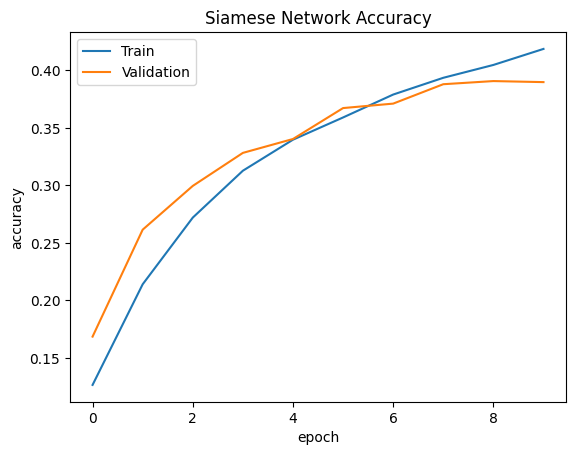

In [85]:
# summarize history for accuracy
plt.plot(average_accuracy_accross_kfold)
plt.plot(average_validation_accuracy_accross_kfold)
plt.title('Siamese Network Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig("outputs/siamases_network_acc.eps", format='eps')
plt.show()




The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


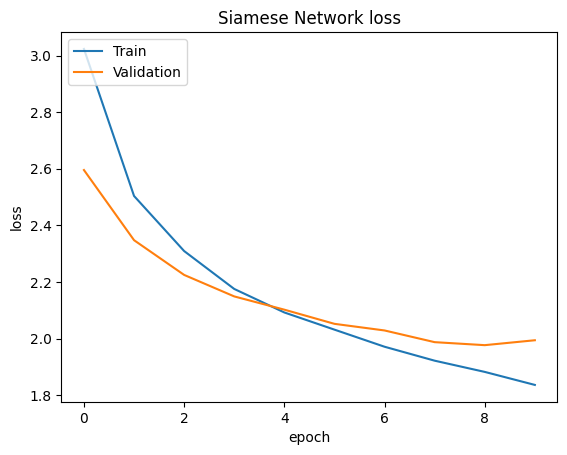

In [86]:
# summarize history for loss
plt.plot(average_loss_accross_kfold)
plt.plot(average_validation_loss_accross_kfold)
plt.title('Siamese Network loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig("outputs/siamese_network_loss.eps", format='eps')
plt.show()
